# House Sales in King County, USA

A dataset from [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction) containing prices of houses is provided.

We want to build a  model that can determine the prices of a given house according to a number of features. We will use a subset of the data for training and the remaining for testing our modeling.

### Outline

We separate the project in 3 steps:

Data Loading and Exploratory Data Analysis: Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

Feature Engineering / Modeling: Once we have the data, we create some features and then the modeling stage begins, making use of different models with different transformers, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

Results and Conclusions: Finally, with our tuned model, we  predict against the test set, then we review those results against their actual values to determine the performance of the model, and finally, outline our conclusions.

In [1]:
# library(e1071)
library(caret)
# library(GGally)
library(ggplot2)
library(lubridate)
library(data.table)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year



### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [2]:
set.seed(9560)

### Data Loading

Here we load the necessary data, describe its contents and print its first rows.

In [3]:
train<-fread('https://gist.githubusercontent.com/akoury/da3cdb6bfde9eb2f3f5d3f5246dfd6b6/raw/1b057c119af85ab22330a50239d5c0bdbab7fb64/train.csv')
test<-fread('https://gist.githubusercontent.com/akoury/83c7ce5544dc467a696967bd13d4f498/raw/e9a54dce92f6d115d1e08cbf7668f5cf70e60598/test.csv')

Warning message in require_bit64():
“Some columns are type 'integer64' but package bit64 is not installed. Those columns will print as strange looking floating point data. There is no need to reload the data. Simply install.packages('bit64') to obtain the integer64 print method and print the data again.”Warning message in require_bit64():
“Some columns are type 'integer64' but package bit64 is not installed. Those columns will print as strange looking floating point data. There is no need to reload the data. Simply install.packages('bit64') to obtain the integer64 print method and print the data again.”

In [8]:
str(train)

Classes ‘data.table’ and 'data.frame':	17277 obs. of  21 variables:
 $ id           : 'integer64' num  4.54e-314 2.29e-315 1.10e-314 3.05e-314 3.16e-314 ...
 $ date         : chr  "5/13/2014" "8/27/2014" "7/18/2014" "1/30/2015" ...
 $ price        : num  225000 641250 810000 330000 530000 ...
 $ bedrooms     : int  3 3 4 4 4 4 4 3 4 3 ...
 $ bathrooms    : num  1.5 2.5 3.5 1.5 1.75 3.5 3.25 2.25 2.5 1.5 ...
 $ sqft_living  : int  1250 2220 3980 1890 1814 3120 4160 1440 2250 2540 ...
 $ sqft_lot     : int  7500 2550 209523 7540 5000 5086 47480 10500 6840 9520 ...
 $ floors       : num  1 3 2 1 1 2 2 1 2 1 ...
 $ waterfront   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ view         : int  0 2 2 0 0 0 0 0 0 0 ...
 $ condition    : int  3 3 3 4 4 3 3 3 3 3 ...
 $ grade        : int  7 10 9 7 7 9 10 8 9 8 ...
 $ sqft_above   : int  1250 2220 3980 1890 944 2480 4160 1130 2250 1500 ...
 $ sqft_basement: int  0 0 0 0 870 640 0 310 0 1040 ...
 $ yr_built     : int  1967 1990 2006 1967 1951 2008 1995 1983

In [4]:
summary(train)

       id        date               price            bedrooms     
 Min.   :0   Length:17277       Min.   :  78000   Min.   : 1.000  
 1st Qu.:0   Class :character   1st Qu.: 320000   1st Qu.: 3.000  
 Median :0   Mode  :character   Median : 450000   Median : 3.000  
 Mean   :0                      Mean   : 539865   Mean   : 3.369  
 3rd Qu.:0                      3rd Qu.: 645500   3rd Qu.: 4.000  
 Max.   :0                      Max.   :7700000   Max.   :33.000  
   bathrooms      sqft_living       sqft_lot           floors     
 Min.   :0.500   Min.   :  370   Min.   :    520   Min.   :1.000  
 1st Qu.:1.750   1st Qu.: 1430   1st Qu.:   5050   1st Qu.:1.000  
 Median :2.250   Median : 1910   Median :   7620   Median :1.500  
 Mean   :2.114   Mean   : 2080   Mean   :  15186   Mean   :1.493  
 3rd Qu.:2.500   3rd Qu.: 2550   3rd Qu.:  10695   3rd Qu.:2.000  
 Max.   :8.000   Max.   :13540   Max.   :1164794   Max.   :3.500  
   waterfront            view          condition         grade

In [5]:
head(train)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,⋯,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4.537352e-314,5/13/2014,225000,3,1.50,1250,7500,1,0,0,⋯,7,1250,0,1967,0,98030,47.3719,-122.215,1260,7563
2.292468e-315,8/27/2014,641250,3,2.50,2220,2550,3,0,2,⋯,10,2220,0,1990,0,98117,47.6963,-122.393,2200,5610
1.098841e-314,7/18/2014,810000,4,3.50,3980,209523,2,0,2,⋯,9,3980,0,2006,0,98024,47.5574,-121.890,2220,65775
3.045372e-314,1/30/2015,330000,4,1.50,1890,7540,1,0,0,⋯,7,1890,0,1967,0,98155,47.7534,-122.318,1890,8515
3.158069e-314,5/23/2014,530000,4,1.75,1814,5000,1,0,0,⋯,7,944,870,1951,0,98115,47.6840,-122.281,1290,5000
3.939779e-314,5/20/2014,953007,4,3.50,3120,5086,2,0,0,⋯,9,2480,640,2008,0,98115,47.6762,-122.288,1880,5092


### Missing Data

We check if there is any missing data per column.

In [11]:
sapply(train, function(x) sum(is.na(x)))

id          date         price      bedrooms     bathrooms 
            0             0             0             0             0 
  sqft_living      sqft_lot        floors    waterfront          view 
            0             0             0             0             0 
    condition         grade    sqft_above sqft_basement      yr_built 
            0             0             0             0             0 
 yr_renovated       zipcode           lat          long sqft_living15 
            0             0             0             0             0 
   sqft_lot15 
            0

### Duplicated

In [5]:
any(duplicated(train))

[1] FALSE

### Converting column types
Now we convert the data types of multiple columns.

#### Numericals

In [4]:
train[ , which(sapply(train, is.integer)):=lapply(.SD,as.numeric), .SDcols = sapply(train, is.integer)]
test[ , which(sapply(test, is.integer)):=lapply(.SD,as.numeric), .SDcols = sapply(test, is.integer)]

#### Dates
We extract the year, month and days since posting

In [5]:
train$date<-mdy(train$date)
train$year<-year(train$date)
train$month<-month(train$date)
train$days_since<-as.numeric(Sys.Date() - train$date)

test$date<-mdy(test$date)
test$year<-year(test$date)
test$month<-month(test$date)
test$days_since<-as.numeric(Sys.Date() - test$date)

#### Categories

In [75]:
# # lets now turn characters into factors
# # still some integer variables...
# data_proc[ , names(data_proc)[sapply(data_proc, is.character)]:=lapply(.SD,as.factor),
#            .SDcols = names(data_proc)[sapply(data_proc, is.character)]]

# # lets re-order the factor levels of make in decreasing order
# data_proc[, make:=factor(make, levels=names(sort(summary(data_proc$make), dec=T)))]
# levels(data_proc$make)

# # We will create a label that will agregate into "others" those makers with less than 3% of share
# niche_cars<-names(which(summary(data_proc$make)/nrow(data_proc)<0.03))
# niche_cars
# data_proc[, make_agg:=as.factor(ifelse(make%in%niche_cars,'others',as.character(make)))]
# # we drop off the former make variable
# data_proc[, make:=NULL]


# # Now lets check the number of categories per factor variable

# factor_variables<-names(data_proc)[sapply(data_proc, is.factor)]
# count_factor_variables<-sapply(data_proc[,factor_variables, with=F], summary)
# count_factor_variables

# # lets define a rule... if a label weight less than 10% goes into the "others" bag:
# f_other<-function(var){
  
#   count_levels<-summary(var)/length(var)
#   to_bag<-names(which(count_levels<0.1))
  
#   reduced_var<-as.factor(ifelse(as.character(var)%in%to_bag,'others',as.character(var)))
  
#   return(reduced_var)
# }

# # and we apply the function to our factor variables
# data_proc[, (factor_variables):=lapply(.SD, f_other), .SDcols=factor_variables]

# sapply(data_proc[,factor_variables, with=F], summary)

### Dropping initial columnss
Now we drop unneeded columns.

In [6]:
train[, c('id','date'):=NULL]
test[, c('id','date'):=NULL]

head(train)

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,⋯,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,days_since
225000,3,1.50,1250,7500,1,0,0,3,7,⋯,1967,0,98030,47.3719,-122.215,1260,7563,2014,5,1834
641250,3,2.50,2220,2550,3,0,2,3,10,⋯,1990,0,98117,47.6963,-122.393,2200,5610,2014,8,1728
810000,4,3.50,3980,209523,2,0,2,3,9,⋯,2006,0,98024,47.5574,-121.890,2220,65775,2014,7,1768
330000,4,1.50,1890,7540,1,0,0,4,7,⋯,1967,0,98155,47.7534,-122.318,1890,8515,2015,1,1572
530000,4,1.75,1814,5000,1,0,0,4,7,⋯,1951,0,98115,47.6840,-122.281,1290,5000,2014,5,1824
953007,4,3.50,3120,5086,2,0,0,3,9,⋯,2008,0,98115,47.6762,-122.288,1880,5092,2014,5,1827


## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model.

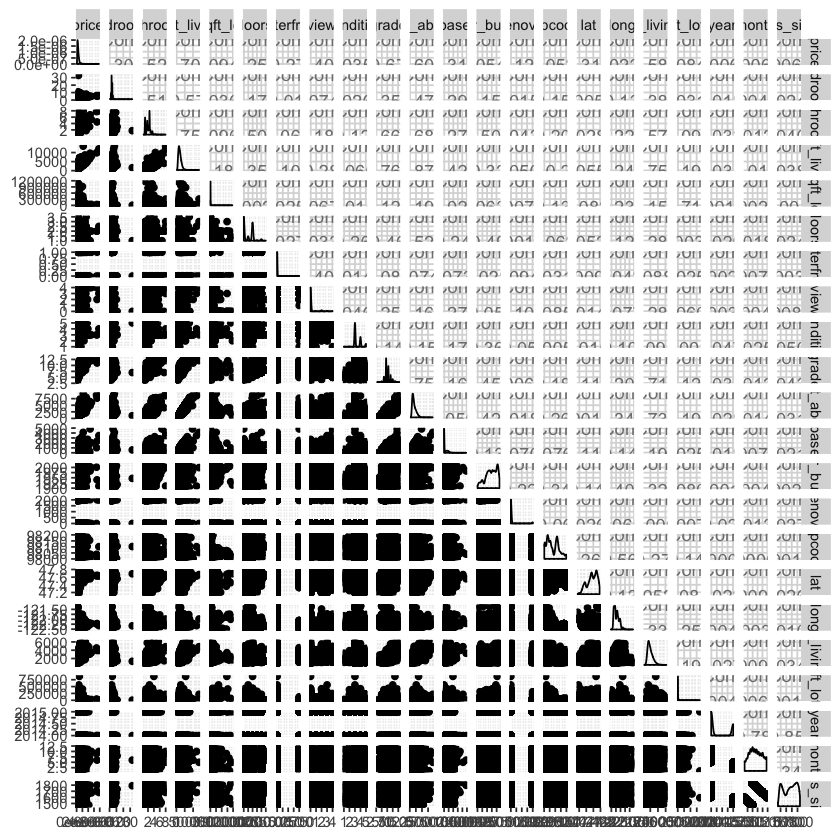

In [88]:
ggpairs(train)

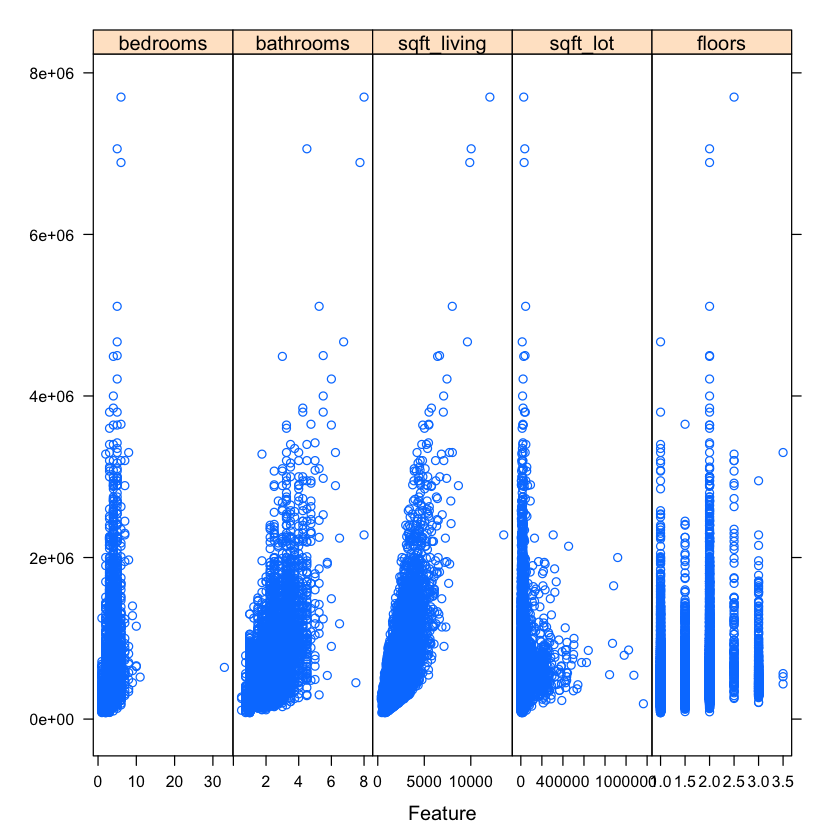

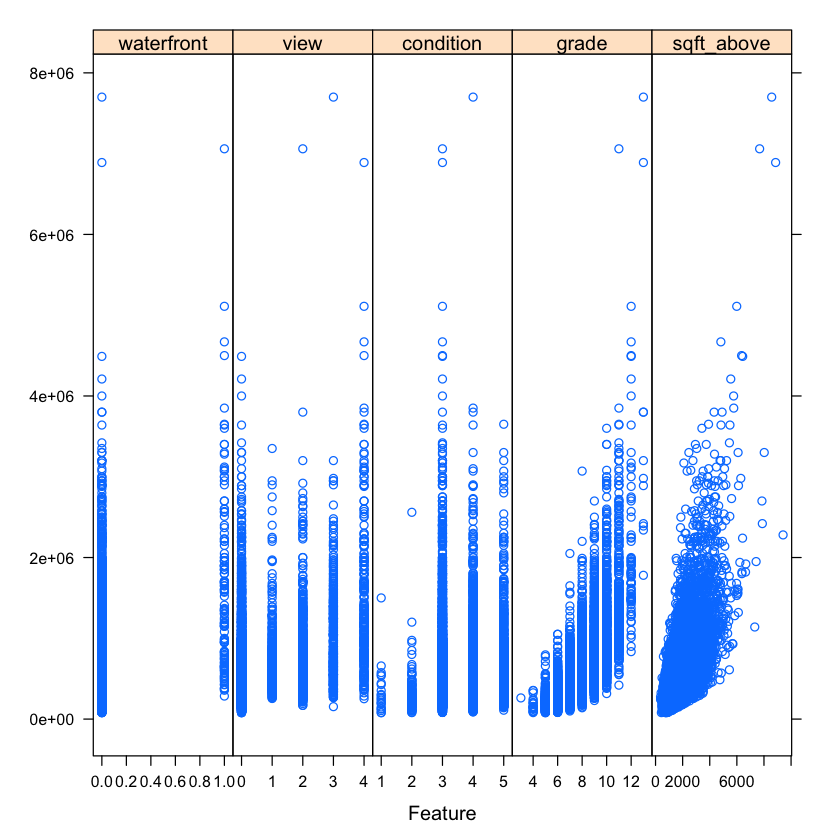

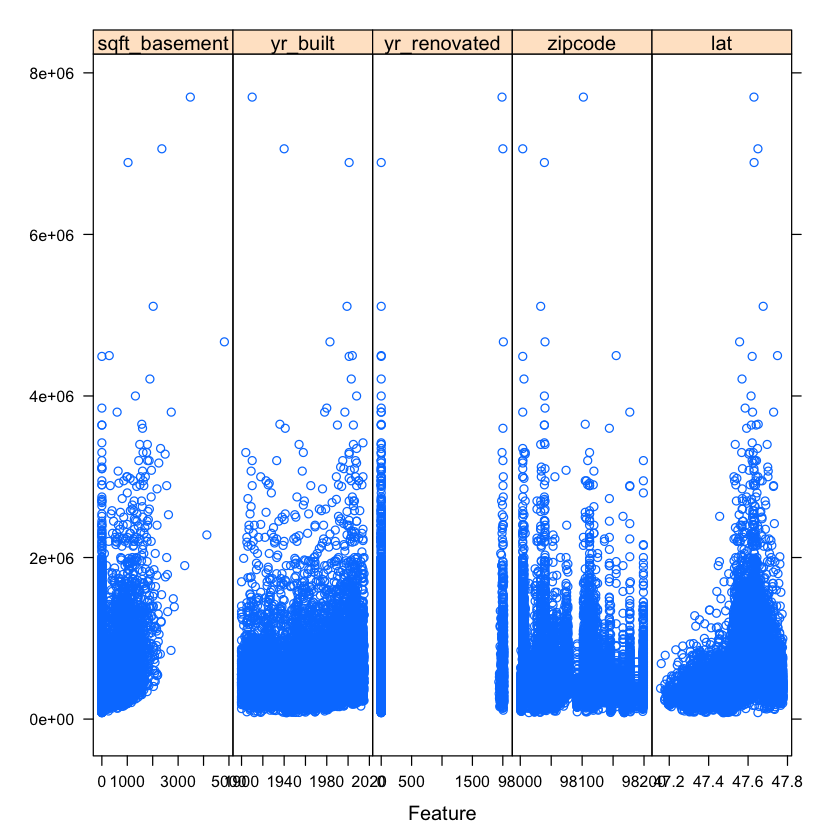

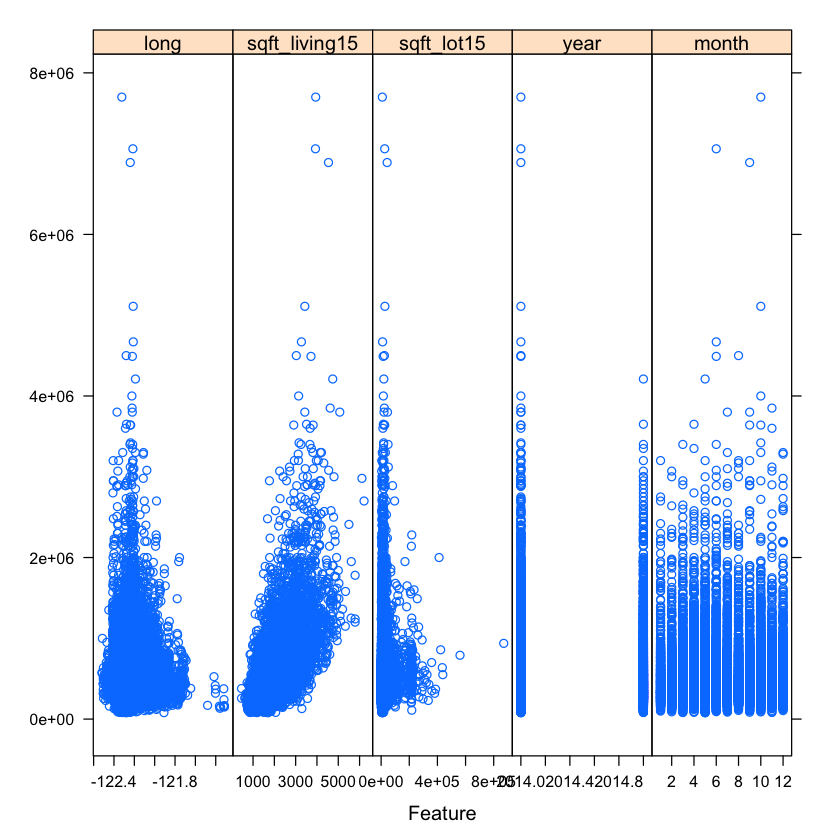

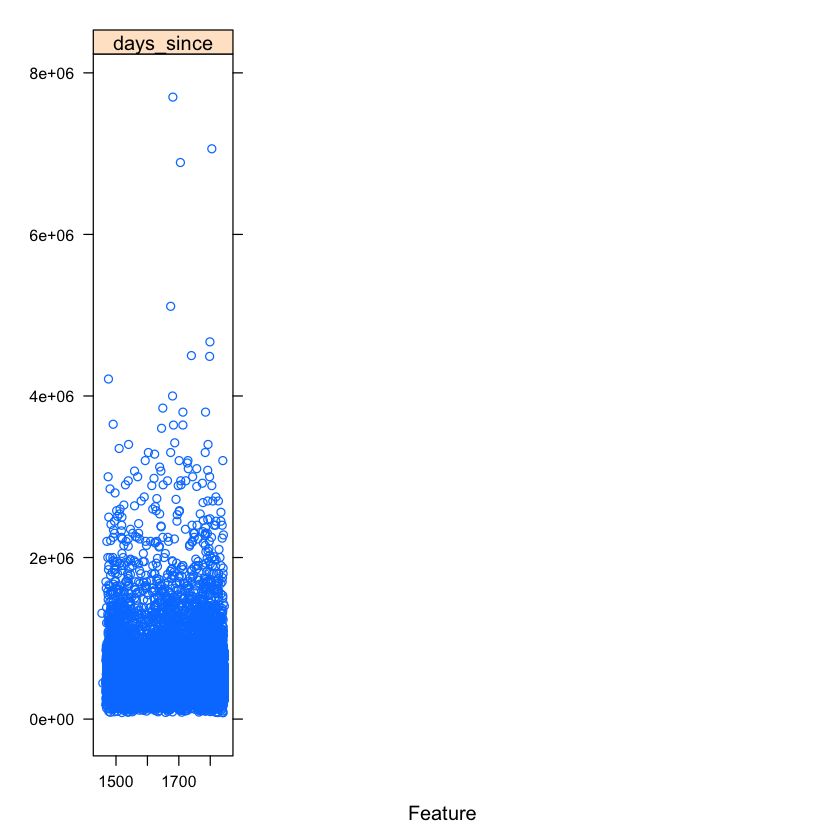

In [29]:
featurePlot(x = train[, -"price"], 
            y = train$price, 
            plot = "scatter", 
            layout = c(5, 1))

### Values per level

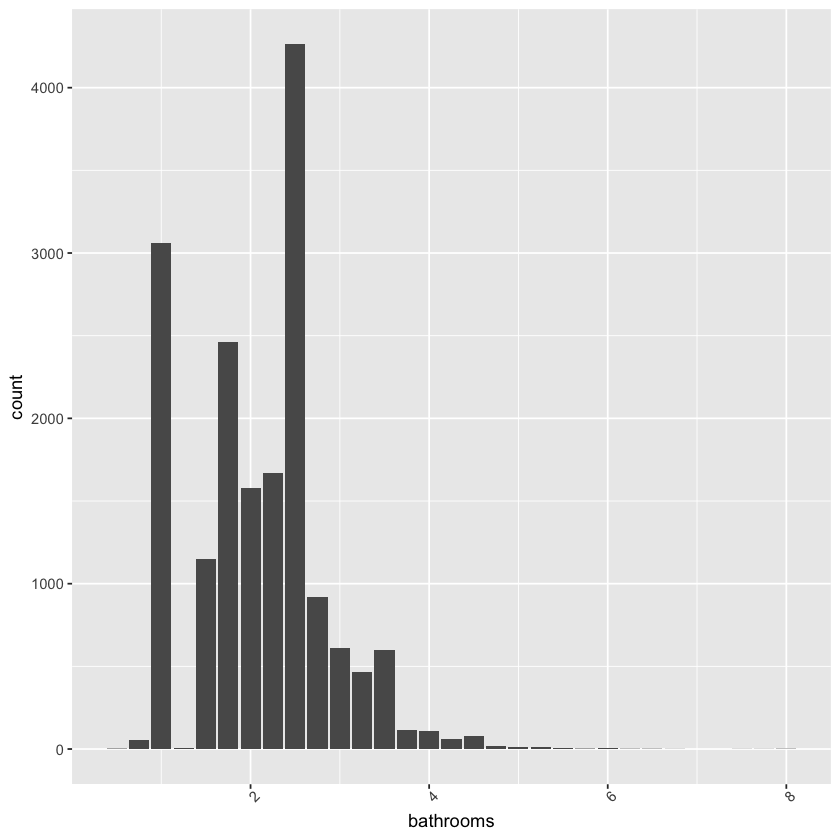

In [30]:
ggplot(train, aes(x=bathrooms))+geom_bar(stat='count')+
  theme(axis.text.x = element_text(angle=45))

### Coefficient of Variation

The coefficient of variation is a dimensionless meassure of dispersion in data, the lower the value the less dispersion a feature has. We will select columns that have a variance of less than 0.05 since they would probably perform poorly.

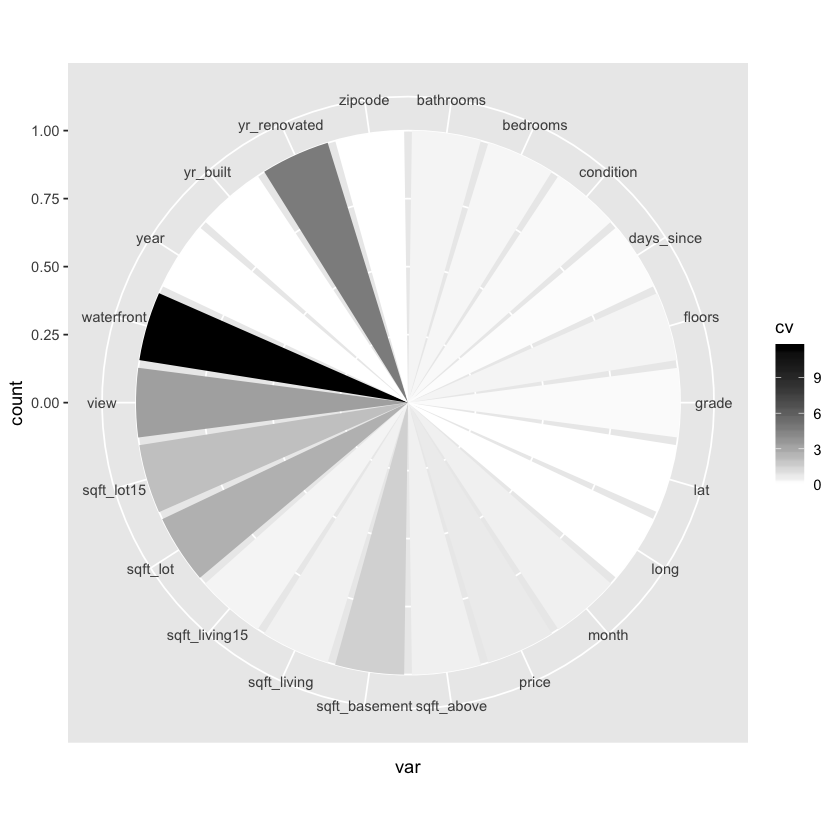

In [31]:
numeric_variables<-names(train)[sapply(train, is.numeric)]

sd_numeric_variables<-sapply(train[,numeric_variables, with=F], sd)
cv_numeric_variables<-sd_numeric_variables/colMeans(train[,numeric_variables, with=F])

ggplot(data.table(var=names(cv_numeric_variables),cv=cv_numeric_variables),
       aes(var,fill=cv))+geom_bar()+coord_polar()+scale_fill_gradient(low='white', high = 'black')

### Boxplot of Numerical Variables

We review the distribution of scaled numerical data through a boxplot for each variable.

yr_built       zipcode           lat          long          year 
 0.0149032058  0.0005462536  0.0029200229 -0.0011541909  0.0002320742 
   days_since 
 0.0679687060

No id variables; using all as measure variables


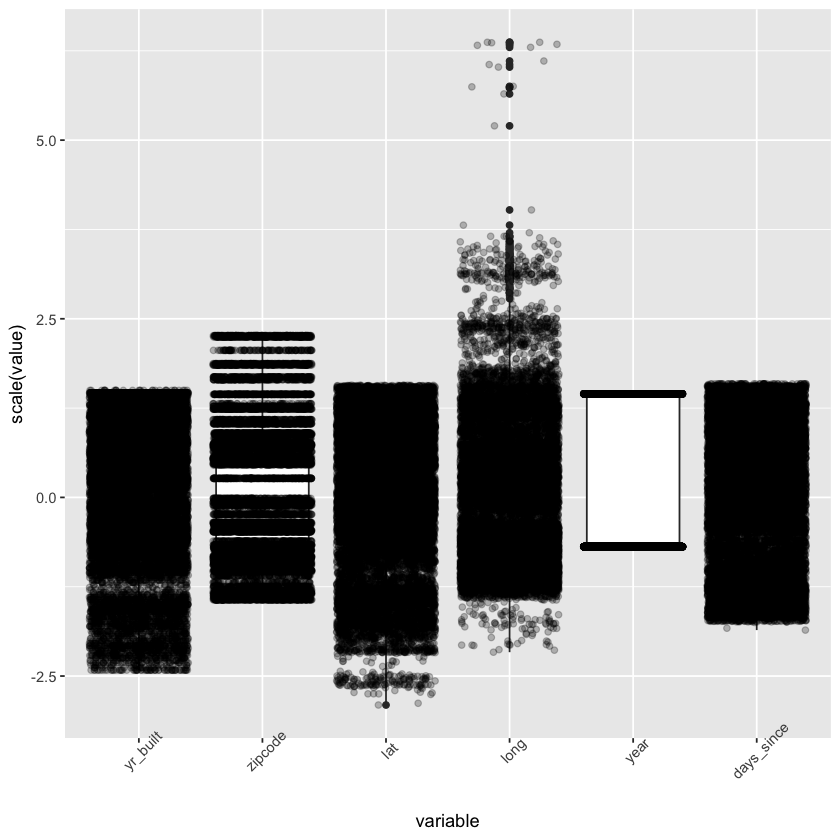

In [35]:
df<-train[, numeric_variables[cv_numeric_variables<0.1], with=F]
sapply(df, function(x) sd(x)/mean(x))
df<-data.frame(scale(df))
df<-melt(df)
       
ggplot(df, aes(x=variable, y=scale(value)))+geom_boxplot()+geom_jitter(alpha=.25)+
  theme(axis.text.x = element_text(angle=45))

# Map

In [ ]:
# KCHouseData$PriceBin<-cut(KCHouseData$price, c(0,250e3,500e3,750e3,1e6,2e6,999e6))

# center_lon = median(KCHouseData$long,na.rm = TRUE)
# center_lat = median(KCHouseData$lat,na.rm = TRUE)

# factpal <- colorFactor(c("black","blue","yellow","orange","#0B5345","red"), 
#                        KCHouseData$PriceBin)



# leaflet(KCHouseData) %>% addProviderTiles("Esri.NatGeoWorldMap") %>%
#   addCircles(lng = ~long, lat = ~lat, 
#              color = ~factpal(PriceBin))  %>%
#   # controls
#   setView(lng=center_lon, lat=center_lat,zoom = 12) %>%
  
#   addLegend("bottomright", pal = factpal, values = ~PriceBin,
#             title = "House Price Distribution",
#             opacity = 1)

### Data Correlation

Now we analyze correlation in the data for both numerical and categorical columns, using a threshold of 85%.

In [36]:
cor<-as.data.frame(as.table(cor(train)))
subset(cor, abs(Freq) > 0.85 & abs(Freq) < 1)

,Var1,Var2,Freq
77,sqft_above,sqft_living,0.8779126
224,sqft_living,sqft_above,0.8779126
440,days_since,year,-0.8537804
482,year,days_since,-0.8537804


### Linear Dependencies

Caret uses QR decomposition to enumerate sets of linear combinations and therefore, remove them

In [37]:
lc<-findLinearCombos(train)
lc

$linearCombos
$linearCombos[[1]]
[1] 12  4 11


$remove
[1] 12

In [38]:
colnames(train[, 12])

[1] "sqft_basement"

### Underrepresented Features

Now we determine underrepresented features, meaning those that in more than X% of the records are composed of a single value.

## Feature Engineering

A number of different combinations of feature engineering steps and transformations will be performed.

### Drop correlated and linear combinations

In [ ]:
# train[, c('id','date'):=NULL]
# test[, c('id','date'):=NULL]

### Center, Scaling, Yeo Johnson, Zero Variance

The Yeo–Johnson transformation allows also for zero and negative values of y. We add a filter to check for zero- or near zero-variance predictors shicen this may cause certain models to crash or the fit to be unstable.

In [79]:
preProcess(train, method = c("center", "scale", "YeoJohnson", "nzv"))
# pp_hpc<-preProcess(train, method = c("center", "scale", "YeoJohnson"))

Created from 17277 samples and 22 variables

Pre-processing:
  - centered (22)
  - ignored (0)
  - scaled (22)
  - Yeo-Johnson transformation (15)

Lambda estimates for Yeo-Johnson transformation:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.6843 -0.4106 -0.2146 -0.2074  0.1499  2.5153 


In [ ]:
transformed <- predict(pp_hpc, newdata = schedulingData[, -8])
head(transformed)

### Kmeans lat long

In [96]:
clusters <- kmeans(train[,16:17], 4)
data14$Borough <- as.factor(clusters$cluster)
str(clusters)

List of 9
 $ cluster     : int [1:17277] 3 4 1 4 4 4 1 3 3 4 ...
 $ centers     : num [1:4, 1:2] 47.6 47.5 47.4 47.7 -122 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "1" "2" "3" "4"
  .. ..$ : chr [1:2] "lat" "long"
 $ totss       : num 677
 $ withinss    : num [1:4] 68.8 29.3 66.6 36
 $ tot.withinss: num 201
 $ betweenss   : num 476
 $ size        : int [1:4] 3813 3949 4038 5477
 $ iter        : int 4
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


### RFE

In [40]:
# functions rfFuncs, method rf

ctrl <- rfeControl(functions = lmFuncs,
                   method = "repeatedcv",
                   number = 5,
                   repeats = 5,
                   verbose = FALSE)

lmProfile <- rfe(train[,-"price"], train$price,
                 rfeControl = ctrl)

lmProfile

Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, x):
“prediction from a rank-deficient fit may be misleading”Warning message in p


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables   RMSE Rsquared    MAE RMSESD RsquaredSD MAESD Selected
         4 321292   0.2233 198708  30943   0.130780 16522         
         8 231189   0.6024 145000  12312   0.016422  2123         
        16 199186   0.7051 125545   8944   0.010012  1823         
        21 198893   0.7060 125335   8961   0.009883  1833        *

The top 5 variables (out of 21):
   lat, waterfront, long, year, grade


In [100]:
predictors(lmProfile)

[1] "lat"           "waterfront"    "long"          "year"         
 [5] "grade"         "view"          "bathrooms"     "bedrooms"     
 [9] "condition"     "month"         "floors"        "yr_built"     
[13] "zipcode"       "days_since"    "sqft_living"   "sqft_above"   
[17] "yr_renovated"  "sqft_living15" "sqft_lot15"    "sqft_lot"     
[21] "sqft_basement"

### Principal Component Analysis (PCA)

We plot PCA component variance to define the number of components we wish to consider if at all.

In [ ]:
# PCAData = KCHouseData %>%
#   select(lat,long)

# pca = prcomp(PCAData, scale. = T)

# KCHouseData_pca <- predict(pca, newdata = PCAData)

# KCHouseData_pca = as.data.frame(KCHouseData_pca)

# KCHouseData2 = cbind(KCHouseData2,KCHouseData_pca)

### One Hot Encoding Categoricals

In [ ]:
# df1$zipcode <- as.factor(df1$zipcode)
# df1$grade <- as.factor(df1$grade)
# df1$waterfront <- as.factor(df1$waterfront)
# df1$floors <- as.factor(df1$floors)
# df1$bedrooms <- as.factor(df1$bedrooms)

# #One Hot Encode
# data_ready<-caret::dummyVars(formula= ~., data = data_proc, fullRank=T,sep = "_")
# data_ready<-data.table(predict(data_ready, newdata = data_proc))

# names(data_ready)<-gsub('-','_',names(data_ready))

## Modeling

After the previous feature engineering steps, different models will be cross validated to accurately review the performance of it.

### Defining Cross Validation

In [67]:
customMetrics <- function (data, lev = NULL, model = NULL) {
    c(
        MAPE = mean(abs(data$obs - data$pred)/data$obs),
        MAE = mean(abs(data$obs - data$pred)),
        RMSE = sqrt(mean((data$obs-data$pred)^2)),
        Rsquared = summary(lm(pred ~ obs, data))$r.squared
    )
}

In [71]:
tc<-trainControl(
        method = "cv",
        number=5,
        savePredictions = TRUE,
        summaryFunction = customMetrics)

### Linear Regression

In [72]:
lm <- train(price~ ., data = train, method = "lm", trControl=tc)

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”

### Random Forest

In [ ]:
rf <- train(price~ ., data = train, method = "ranger", trControl=tc, importance = "impurity")

### XGBoost

In [54]:
xgb <- train(price~ ., data = train, method = "xgbTree", trControl=tc, importance = TRUE)

### Scores: Comparing Models

### Importances

In [ ]:
plot(varImp(lm), top = 10)
plot(varImp(rf), top = 10)
plot(varImp(xgb), top = 10)

In [82]:
results <- resamples(list(LM = lm,
                          RF = rf,
                          XGB = xgb))
results


Call:
resamples.default(x = list(LM = lm, RF = rf, XGB = xgb))

Models: LM, RF, XGB 
Number of resamples: 5 
Performance metrics: MAE, RMSE, Rsquared 
Time estimates for: everything, final model fit 

In [83]:
summary(results)


Call:
summary.resamples(object = resamps)

Models: LM, RF, XGB 
Number of resamples: 5 

MAE 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM  122846.07 124765.43 125777.19 125282.50 126313.30 126710.50    0
RF   65868.72  67988.86  69804.05  68991.66  70607.25  70689.41    0
XGB  70968.53  71072.00  72384.58  72356.42  72388.60  74968.42    0

RMSE 
        Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
LM  181025.4 195193.4 201639.1 198734.6 206456.6 209358.5    0
RF  119489.8 126797.4 127063.1 127323.5 130780.4 132487.0    0
XGB 115469.1 120464.1 125321.8 125495.6 132977.4 133245.4    0

Rsquared 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LM  0.6963464 0.6989935 0.7053990 0.7064716 0.7118868 0.7197323    0
RF  0.8698287 0.8716445 0.8832814 0.8804547 0.8865240 0.8909951    0
XGB 0.8756508 0.8785306 0.8818604 0.8833663 0.8871249 0.8936647    0


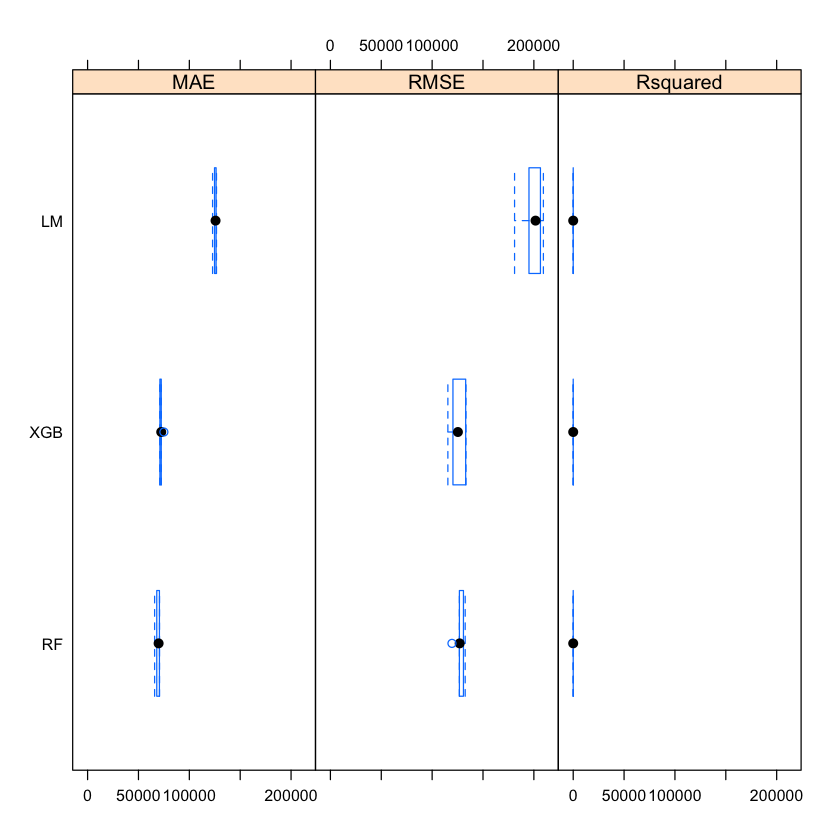

In [91]:
bwplot(resultss, layout = c(3, 1))

## Hyperparameter Tuning

Once we have a list of models, we perform a cross validated, randomized grid search on the best performing one to define the final model.

In [ ]:
# gbmGrid <-  expand.grid(interaction.depth = c(1, 5, 9), 
#                         n.trees = (1:30)*50, 
#                         shrinkage = 0.1,
#                         n.minobsinnode = 20)
                        
# nrow(gbmGrid)

# set.seed(825)
# gbmFit2 <- train(Class ~ ., data = training, 
#                  method = "gbm", 
#                  trControl = fitControl, 
#                  verbose = FALSE, 
#                  ## Now specify the exact models 
#                  ## to evaluate:
#                  tuneGrid = gbmGrid)
# gbmFit2

In [ ]:
# 1. Define our grid of hyperparameters to tune
tuneGrid=data.table(expand.grid(mtry=c(5,15),
                                splitrule='variance',
                                min.node.size=c(2,5,10)))


dim(tuneGrid)
tuneGrid


# 2. Define the validation squema
ctrl <- trainControl(
  method = "cv",
  number = 10,
  savePredictions=TRUE
)

# 3. Train the model
ini<-now()
set.seed(123)
rangerFit <- train(
  formula,
  data = whole_data$train,
  method = "ranger", num.trees=1000,
  preProc = NULL, 
  tuneGrid = tuneGrid,
  trControl = ctrl,
  metric = "MAE"
)
print(now()-ini)


rangerFit


# inspecting the most relevant features: 
rangerFit$results
rangerFit$bestTune
rangerFit$finalModel

# we can access the K-fold validation predictions
str(rangerFit$pred)
pred_cv<-data.table(rangerFit$pred)
pred_cv[Resample=='Fold1'&mtry==5&min.node.size==5]

# and visualize a CV summary using the established metric
plot(rangerFit)

### RANDOMIZED

In [ ]:
# Again, we will use the sonar data from the previous training page to demonstrate the method with a regularized discriminant analysis by looking at a total of 30 tuning parameter combinations:

fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 10,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary,
                           # THIS MATTERS
                           search = "random")

set.seed(825)
rda_fit <- train(Class ~ ., data = training, 
                  method = "rda",
                  metric = "ROC",
                  # THIS MATTERS
                  tuneLength = 30,
                  trControl = fitControl)
rda_fit

### Fit to all train data

In [ ]:
# 4. Fit the model to all train data
library(ranger)
ini<-now()
finalmodel<-ranger(formula, data=whole_data$train,num.trees=1000,
                   mtry=rangerFit$bestTune$mtry,
                   min.node.size=rangerFit$bestTune$min.node.size)

print(now()-ini)

# Results
We evaluate the final model with the holdout, obtaining the definitive score of the model.

In [ ]:
predicted <- predict(rf, newdata = test)
df_pred<-cbind(test, predictions(predicted))
head(predicted)

# Conclusions

In [ ]:
# RFFit <- train(Defect ~., data=trainingSet, method="rf", trControl=tc, preProc=c("center", "scale"))
# RF.testSet$Prediction <- predict(RFFit, newdata=testSet)

# run in parallel

In [ ]:
# library(doParallel)
# cluster <- makeCluster(detectCores() - 1)
# or
# cl <- makePSOCKcluster(5)
# registerDoParallel(cl)

# ## All subsequent models are then run in parallel
# model <- train(y ~ ., data = training, method = "rf")

# ## When you are done:
# stopCluster(cl)